<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
!pip install keras.preprocessing



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00


In [3]:
!pip install contractions --quiet
!pip install nltk --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.8 MB/s eta 0:00:00


In [4]:
import re
import numpy as np
import pandas as pd
import json
import os
import gdown
import contractions # For better contraction handling
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# --- Configuration ---
config = {
    "dataset_url": 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download',
    "dataset_filename": 'data_volunteers.json',
    "glove_url": "http://nlp.stanford.edu/data/glove.6B.zip",
    "glove_zip": "glove.6B.zip",
    "glove_file": "glove.6B.100d.txt",
    "embedding_dim": 100,
    "max_vocab_size": 15000, # Increased vocab size slightly
    "max_input_token_len": 40, # Filter based on tokens now
    "max_output_token_len": 40, # Filter based on tokens now
    "lstm_units": 384, # Increased units slightly from 256
    "dropout_rate": 0.3, # Added dropout
    "recurrent_dropout_rate": 0.3, # Added recurrent dropout
    "batch_size": 64,
    "epochs": 100, # Increased epochs, but EarlyStopping will control duration
    "validation_split": 0.2,
    "early_stopping_patience": 10,
    "lr_plateau_patience": 5,
    "lr_plateau_factor": 0.2,
}


In [8]:
# --- Download NLTK Data
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:  # Catch LookupError for missing resource
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:  # Catch LookupError here as well
    nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
# --- Helper Functions ---

def download_file(url, output_filename, desc="file"):
    """Downloads a file if it doesn't exist."""
    if not os.path.exists(output_filename):
        print(f"Downloading {desc}...")
        gdown.download(url, output_filename, quiet=False)
    else:
        print(f"{desc} already downloaded: {output_filename}")

def download_and_extract_zip(url, output_zip, extracted_file, desc="zip file"):
    """Downloads and extracts a zip file if the target file doesn't exist."""
    if not os.path.exists(extracted_file):
        if not os.path.exists(output_zip):
             print(f"Downloading {desc}...")
             gdown.download(url, output_zip, quiet=False)
        else:
            print(f"{desc} already downloaded: {output_zip}")

        print(f"Extracting {output_zip}...")
        import zipfile
        with zipfile.ZipFile(output_zip, 'r') as zip_ref:
            zip_ref.extractall('.')
        print(f"Extracted to current directory.")
        if not os.path.exists(extracted_file):
             print(f"Warning: Expected extracted file {extracted_file} not found after extraction.")
    else:
        print(f"Required file already exists: {extracted_file}")

lemmatizer = WordNetLemmatizer()

In [11]:
def clean_text(text):
    """
    Cleans text data: lowercase, expand contractions, lemmatize, remove non-alphanumeric (keep spaces).
    Handles the bug from the original script and uses lemmatization.
    """
    text = text.lower()
    # Expand contractions (more robustly)
    text = contractions.fix(text)
    # Lemmatize: asocio los token con raices comunes, como diferentes conjugaciones de un mismo verbo
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    # Keep only alphanumeric and spaces, replace others with space
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text




In [12]:
def load_and_preprocess_data(filename, max_input_len, max_output_len):
    """
    Loads data, cleans text, creates input/output pairs, and filters by TOKEN length.
    """
    print("Loading and preprocessing data...")
    with open(filename) as f:
        data = json.load(f)

    input_texts = []
    output_texts_input = [] # Decoder input (<sos> + sentence)
    output_texts_target = [] # Decoder target (sentence + <eos>)

    skipped_count = 0
    total_pairs = 0

    for conversation in data:
      #las pares con respuestas y las impares preguntas
        for i in range(len(conversation['dialog']) - 1):
            total_pairs += 1
            input_raw = conversation['dialog'][i]['text']
            output_raw = conversation['dialog'][i+1]['text']

            # Clean texts
            input_cleaned = clean_text(input_raw)
            output_cleaned = clean_text(output_raw)

            # Tokenize temporarily for length check
            input_tokens = input_cleaned.split()
            output_tokens = output_cleaned.split()

            # Filter based on TOKEN length
            if len(input_tokens) > max_input_len or len(output_tokens) > max_output_len \
               or not input_tokens or not output_tokens: # Skip empty sequences
                skipped_count += 1
                continue

            # Prepare decoder input and target
            output_input = '<sos> ' + output_cleaned
            output_target = output_cleaned + ' <eos>'

            input_texts.append(input_cleaned)
            output_texts_input.append(output_input)
            output_texts_target.append(output_target)

    print(f"Total potential pairs: {total_pairs}")
    print(f"Pairs skipped due to length/emptiness: {skipped_count}")
    print(f"Pairs used for training: {len(input_texts)}")
    return input_texts, output_texts_input, output_texts_target


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [13]:
def tokenize_and_pad(input_texts, output_texts_input, output_texts_target,
                     max_vocab_size, max_input_len, max_output_len):
    """
    Tokenizes text, pads sequences, and returns tokenizers and processed sequences.
    Uses separate tokenizers, handles <unk>, uses pre-padding for encoder.
    """
    print("Tokenizing and padding sequences...")

    # Input Tokenizer (Encoder)
    tokenizer_inputs = Tokenizer(num_words=max_vocab_size, oov_token='<unk>')
    tokenizer_inputs.fit_on_texts(input_texts)
    encoder_input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
    encoder_input_sequences = pad_sequences(encoder_input_sequences, maxlen=max_input_len, padding='pre') # Pre-padding for encoder
    word2idx_inputs = tokenizer_inputs.word_index
    # Uso prepadding porque como es la última neurona la que pasa su estado al decoder puede ser que se diluya la información valiosa en los pasos que hace sobre el padding
    num_words_inputs = min(max_vocab_size, len(word2idx_inputs) + 1)
    print(f"Input Vocab Size (used): {num_words_inputs-1} (+1 for padding)")


    # Output Tokenizer (Decoder) - Fit on both input and target to include <sos> and <eos>
    # filters='' ensures '<sos>' and '<eos>' are kept
    tokenizer_outputs = Tokenizer(num_words=max_vocab_size, oov_token='<unk>', filters='')
    tokenizer_outputs.fit_on_texts(output_texts_input + output_texts_target)
    decoder_input_sequences = tokenizer_outputs.texts_to_sequences(output_texts_input)
    decoder_target_sequences = tokenizer_outputs.texts_to_sequences(output_texts_target)

    decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=max_output_len, padding='post')
    decoder_target_sequences = pad_sequences(decoder_target_sequences, maxlen=max_output_len, padding='post') # Target uses post-padding

    word2idx_outputs = tokenizer_outputs.word_index
    idx2word_outputs = {v: k for k, v in word2idx_outputs.items()} # For decoding
    num_words_outputs = min(max_vocab_size, len(word2idx_outputs) + 1)
    print(f"Output Vocab Size (used): {num_words_outputs-1} (+1 for padding, includes <sos>, <eos>)")


    return (tokenizer_inputs, tokenizer_outputs,
            encoder_input_sequences, decoder_input_sequences, decoder_target_sequences,
            word2idx_inputs, word2idx_outputs, idx2word_outputs,
            num_words_inputs, num_words_outputs,
            max_input_len, max_output_len)



### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [14]:
def load_glove_embeddings(glove_file):
    """Loads GloVe embeddings from a file into a dictionary."""
    print(f"Loading GloVe embeddings from: {glove_file}")
    embeddings_index = {}
    try:
        with open(glove_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    except FileNotFoundError:
        print(f"Error: GloVe file not found at {glove_file}")
        print("Please ensure the GloVe file is downloaded and extracted correctly.")
        return None
    print(f"Found {len(embeddings_index)} word vectors in GloVe.")
    return embeddings_index

In [15]:
def build_embedding_matrix(word_index, embeddings_index, embedding_dim, max_vocab_size):
    """
    Builds an embedding matrix using pre-trained GloVe vectors.
    Handles OOV words by initializing with the mean embedding vector.
    """
    print("Building embedding matrix...")
    num_words = min(max_vocab_size, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    found_vectors = []

    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            found_vectors.append(embedding_vector)

    # Calculate mean vector for OOV initialization (excluding zero vectors)
    if found_vectors:
       mean_vector = np.mean(found_vectors, axis=0)
    else:
       mean_vector = np.random.randn(embedding_dim) * 0.01 # Fallback: small random
       print("Warning: No pre-trained vectors found for vocabulary. Using random init for OOV.")


    # Initialize OOV tokens (index 1 for <unk> by default in Keras Tokenizer)
    # and any other words that weren't found and are still zeros.
    # Also initialize padding token (index 0) just in case, though mask_zero should handle it.
    for i in range(num_words):
       if np.all(embedding_matrix[i] == 0):
           if i == word_index.get('<unk>', -1): # Check if it's the explicit OOV token
               embedding_matrix[i] = mean_vector
               print(f"Initialized <unk> embedding (index {i}) with mean vector.")
           elif i != 0: # Don't override padding token 0 with mean
               embedding_matrix[i] = mean_vector # Initialize other missed words


    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    coverage = len(found_vectors) / (num_words - 2) if (num_words - 2) > 0 else 0 # Exclude padding and potential <unk>
    print(f"Vocabulary coverage by GloVe: {coverage:.2%}")
    return embedding_matrix

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [17]:
def build_seq2seq_model(max_input_len, max_output_len, num_words_inputs, num_words_outputs,
                        embedding_dim, lstm_units, dropout_rate, recurrent_dropout_rate,
                        input_embedding_matrix, output_embedding_matrix):
    """
    Builds the standard Encoder-Decoder model
    Uses fine-tunable embeddings for both encoder and decoder.
    Includes Dropout and Recurrent Dropout.
    """
    print("Building Seq2Seq model")

    # --- Encoder ---
    encoder_inputs = Input(shape=(max_input_len,), name='encoder_input')
    # Use mask_zero=True for pre-padding
    enc_emb_layer = Embedding(num_words_inputs, embedding_dim, weights=[input_embedding_matrix],
                              trainable=True, mask_zero=True, name='encoder_embedding')
    enc_emb = enc_emb_layer(encoder_inputs)
    # Encoder LSTM: Only need the final states, not the full sequence output
    encoder_lstm = LSTM(lstm_units, return_state=True, # return_sequences=False by default is ok, but explicitly set to True for clarity
                        dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate, name='encoder_lstm')
    # We discard the encoder outputs sequence, only keep the states
    _, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c] # Context vector (last state)

    # --- Decoder ---
    decoder_inputs = Input(shape=(max_output_len,), name='decoder_input') # Shape for teacher forcing during training
    # Decoder embedding can also be fine-tuned
    dec_emb_layer = Embedding(num_words_outputs, embedding_dim, weights=[output_embedding_matrix],
                              trainable=True, mask_zero=False, name='decoder_embedding') # No mask_zero for post-padding target
    dec_emb = dec_emb_layer(decoder_inputs)

    # Decoder LSTM - returns full sequence for Teacher Forcing alignment
    # Takes the encoder's final states as its initial state
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, # Need sequences for Dense layer over time
                        dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate, name='decoder_lstm')
    # decoder_lstm_outputs shape: (batch_size, max_output_len, lstm_units)
    decoder_lstm_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

    # --- Output Layer ---
    # Dense layer applied directly to the Decoder LSTM outputs

    decoder_dense = Dense(num_words_outputs, activation='softmax', name='decoder_output_dense')
    decoder_outputs = decoder_dense(decoder_lstm_outputs) # Apply Dense to the LSTM sequence output

    # --- Training Model Definition ---
    # Inputs: Encoder sequence, Decoder sequence (for teacher forcing)
    # Outputs: Probability distribution over vocab for each timestep in the output sequence
    training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='training_model')

    # Compile using sparse categorical crossentropy
    training_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print("Model built successfully")
    training_model.summary() # Print model summary
    return training_model

In [18]:
def train_model(model, encoder_input_data, decoder_input_data, decoder_target_data,
                batch_size, epochs, validation_split, early_stopping_patience,
                lr_plateau_patience, lr_plateau_factor):
    """Trains the model with callbacks."""
    print("Starting model training...")

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience,
                                   verbose=1, restore_best_weights=True)
    # Disminuyo la tasa de aprendizaje cuando no veo mejoras para que explore con mas detenimiento el espacio local
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=lr_plateau_factor,
                                  patience=lr_plateau_patience, min_lr=1e-6, verbose=1)

    history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=validation_split,
                        callbacks=[early_stopping, reduce_lr])

    print("Training finished.")
    return history

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [47]:
def build_inference_models(training_model, lstm_units):
    """
    Builds separate encoder and decoder models for inference for a standard Seq2Seq model.
    """
    print("Building inference models")

   # --- Encoder Model ---
    # The encoder's role is just to produce the final context states (h, c)
    # Get the input layer of the training model by name
    encoder_inputs = training_model.get_layer('encoder_input').output
    # Get the encoder LSTM layer by name
    encoder_lstm_layer = training_model.get_layer('encoder_lstm')
    # Get the encoder embedding layer by name
    encoder_embedding_layer = training_model.get_layer('encoder_embedding')

    # Apply the embedding layer to the encoder inputs
    # Changed: Apply the embedding layer inside the Model definition
    # enc_emb = encoder_embedding_layer(encoder_inputs)

    # Get the encoder LSTM outputs (output sequence, state_h, state_c)
    # Changed: Pass encoder_inputs directly to the LSTM through the embedding layer
    # Applying embedding layer here, removed unnecessary encoder_outputs_seq
    enc_emb = encoder_embedding_layer(encoder_inputs)
    _, state_h_enc, state_c_enc = encoder_lstm_layer(enc_emb)
    encoder_states = [state_h_enc, state_c_enc]  # Context vector (last state)

    # Define the encoder model: Input sequence -> Output states [h, c]
    encoder_model = Model(encoder_inputs, encoder_states, name='encoder_inference')
    print("Encoder inference model built.")


   # --- Decoder Model ---
    # Inputs needed for the decoder at each step:
    # 1. The previous predicted token (or <sos> initially)
    # 2. The previous hidden state (h)
    # 3. The previous cell state (c)

    # Define input layers for the states
    decoder_state_input_h = Input(shape=(lstm_units,), name='decoder_state_h_input')
    decoder_state_input_c = Input(shape=(lstm_units,), name='decoder_state_c_input')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    # Input for the single token prediction at each step
    decoder_inputs_single = Input(shape=(1,), name='decoder_token_input') # Input is one token ID

    # Get layers from the trained model
    dec_emb_layer = training_model.get_layer('decoder_embedding')
    decoder_lstm = training_model.get_layer('decoder_lstm') # The actual LSTM layer
    decoder_dense = training_model.get_layer('decoder_output_dense') # The final classification layer

    # Inference Decoder Steps:
    # 1. Embed the input token
    dec_emb_single = dec_emb_layer(decoder_inputs_single)

    # 2. Run the LSTM step using the embedded token and the previous states
    # We get the output for this step and the new states
    decoder_lstm_outputs, state_h_dec, state_c_dec = decoder_lstm(
        dec_emb_single, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec] # New states to pass to the next step

    # 3. Apply the Dense layer to the LSTM output to get token probabilities
    decoder_outputs = decoder_dense(decoder_lstm_outputs)

    # Define the decoder model:
    # Inputs: [Single Token Input, Previous Hidden State, Previous Cell State]
    # Outputs: [Token Probabilities, New Hidden State, New Cell State]
    decoder_model = Model(
        [decoder_inputs_single] + decoder_states_inputs,
        [decoder_outputs] + decoder_states,
        name='decoder_inference'
    )
    print("Decoder inference model built.")

    return encoder_model, decoder_model

In [45]:
def decode_sequence_greedy(input_seq, encoder_model, decoder_model,
                       tokenizer_outputs, idx2word_outputs, max_output_len):
    """Decodes an input sequence using greedy search."""

    # Encode the input sequence to get the initial states
    # Removed encoder_outputs_seq
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Start sequence with '<sos>' token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_outputs.word_index['<sos>']

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        # Predict next token (probabilities) and update states
        # Removed encoder_outputs_seq from predict call
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Get the most likely token ID (greedy)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Use efficient dictionary lookup
        sampled_word = idx2word_outputs.get(sampled_token_index, '<unk>')

        # Stop if '<eos>' is sampled or max length is reached
        if sampled_word == '<eos>' or len(decoded_sentence) >= max_output_len:
            stop_condition = True
        else:
            decoded_sentence.append(sampled_word)

        # Update the target sequence for the next step
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return ' '.join(decoded_sentence)

Ejecución general

In [36]:
# --- Main Execution ---
nltk.download('punkt_tab')
# --- 1. Download Data ---
download_file(config['dataset_url'], config['dataset_filename'], desc="Dataset")
download_and_extract_zip(config['glove_url'], config['glove_zip'], config['glove_file'], desc="GloVe Embeddings")

# --- 2. Load and Preprocess ---
input_texts, output_texts_input, output_texts_target = load_and_preprocess_data(
    config['dataset_filename'],
    config['max_input_token_len'],
    config['max_output_token_len']
)

if not input_texts:
    print("No data loaded after preprocessing. Check filtering criteria or dataset.")
    exit()

# --- 3. Tokenize and Pad ---
(tokenizer_inputs, tokenizer_outputs,
 encoder_input_sequences, decoder_input_sequences, decoder_target_sequences,
 word2idx_inputs, word2idx_outputs, idx2word_outputs,
 num_words_inputs, num_words_outputs,
 max_input_len, max_output_len) = tokenize_and_pad(
    input_texts, output_texts_input, output_texts_target,
    config['max_vocab_size'], config['max_input_token_len'], config['max_output_token_len']
)

# --- 4. Prepare Embeddings ---
embeddings_index = load_glove_embeddings(config['glove_file'])
if embeddings_index is None:
    exit()

input_embedding_matrix = build_embedding_matrix(
    word2idx_inputs, embeddings_index, config['embedding_dim'], num_words_inputs
)
output_embedding_matrix = build_embedding_matrix(
    word2idx_outputs, embeddings_index, config['embedding_dim'], num_words_outputs
)

# --- 5. Build Model ---
training_model = build_seq2seq_model(
    max_input_len, max_output_len, # Use actual padded lengths
    num_words_inputs, num_words_outputs, # Use actual vocab sizes
    config['embedding_dim'], config['lstm_units'],
    config['dropout_rate'], config['recurrent_dropout_rate'],
    input_embedding_matrix, output_embedding_matrix
)

# --- 6. Train Model ---
# Note: decoder_target_sequences does not need to be one-hot encoded when using sparse_categorical_crossentropy
history = train_model(
    training_model,
    encoder_input_sequences, decoder_input_sequences, decoder_target_sequences,
    config['batch_size'], config['epochs'], config['validation_split'],
    config['early_stopping_patience'], config['lr_plateau_patience'], config['lr_plateau_factor']
)




[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Dataset already downloaded: data_volunteers.json
Required file already exists: glove.6B.100d.txt
Loading and preprocessing data...


KeyboardInterrupt: 

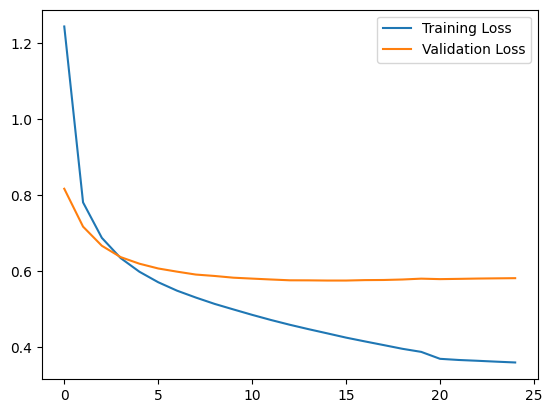

In [25]:
# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Pudo haber un overfitting


In [48]:
 # --- 7. Build Inference Models ---
encoder_inf_model, decoder_inf_model = build_inference_models(
    training_model, config['lstm_units']
)

# --- 8. Inference Example ---
print("\n--- Inference Examples ---")
# Select a few random samples from the validation set (if split used during training)
# or just from the original data
num_examples = 5
for i in np.random.choice(len(encoder_input_sequences), num_examples, replace=False):
    input_seq = encoder_input_sequences[i:i+1] # Need batch dimension
    original_input_text = input_texts[i]
    # Find corresponding original target text (needs careful alignment if validation split was random)
    # For simplicity, let's just show the input and decoded output
    # original_output_text = output_texts_target[i].replace('<eos>', '').strip() # Example if aligned

    decoded_sentence = decode_sequence_greedy(
        input_seq, encoder_inf_model, decoder_inf_model,
        tokenizer_outputs, idx2word_outputs, max_output_len
    )
    print(f"Input:   {original_input_text}")
    # print(f"Original: {original_output_text}") # Uncomment if you have aligned target
    print(f"Decoded: {decoded_sentence}")
    print("-" * 30)

Building inference models
Encoder inference model built.
Decoder inference model built.

--- Inference Examples ---
Input:   i got a job on a gas station i am an engineer
Decoded: that is cool i am a teacher
------------------------------
Input:   i will send you my resume
Decoded: what do you do for a living
------------------------------
Input:   yes they are what do you like to do
Decoded: i do not know what that mean
------------------------------
Input:   do you like car i am a car salesman
Decoded: i do not have a lot of time for that
------------------------------
Input:   great i play guitar and play game a my hobby
Decoded: i love to read
------------------------------


El modelo responde con una gramática bastante buena, pero no llega a ser un dialogo de pregunta y respuesta. Puede ser porque se removieron los signos de pregunta en el preprocesamiento y eso es lo que marcaba la cadencia.